# METHODOLOGIE DE BOX-JANKINS

## 1. Importation des packages

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller,acf
from statsmodels.tsa.arima.model import ARIMA
from  pandas.tseries.offsets import DateOffset
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


import warnings
warnings.filterwarnings('ignore')


Importation de la base de donnees

In [2]:
missing_values=["na","-","I"]
bokhol=pd.read_excel('basedonnees.xlsx',na_values=missing_values,index_col=[0],parse_dates=True)

In [3]:
energie=bokhol[[bokhol.columns[-1]]]
energie.head()

,Production Centrale Meter 1 - (W)
Date (+00:00),
2021-01-01 00:05:00,0.0
2021-01-01 00:10:00,0.0
2021-01-01 00:15:00,0.0
2021-01-01 00:20:00,0.0
2021-01-01 00:25:00,0.0


## 2. Identification du modeles

In [4]:
energie.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105119 entries, 2021-01-01 00:05:00 to 2021-12-31 23:55:00
Data columns (total 1 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Production Centrale Meter 1 - (W)  104502 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [5]:
# detection des vateures manquantes
print(f"le nombre de valeurs manquantes est:{energie.isnull().sum().values}")
print(f"le pourcentages des valeurs manquante:{energie.isnull().sum().values/energie.shape[0]} %")

le nombre de valeurs manquantes est:[617]
le pourcentages des valeurs manquante:[0.00586954] %


In [6]:
# description statistiques de la production energetique
description=energie.describe()
description
#plt.figure(figsize=(15,5))
#plt.bar(description.index,height=description.values)

,Production Centrale Meter 1 - (W)
count,1.045020e+05
mean,4.486998e+06
std,6.034425e+06
min,0.000000e+00
25%,0.000000e+00
50%,1.356000e+05
75%,9.030000e+06
max,5.817720e+07


<AxesSubplot:xlabel='Date (+00:00)'>

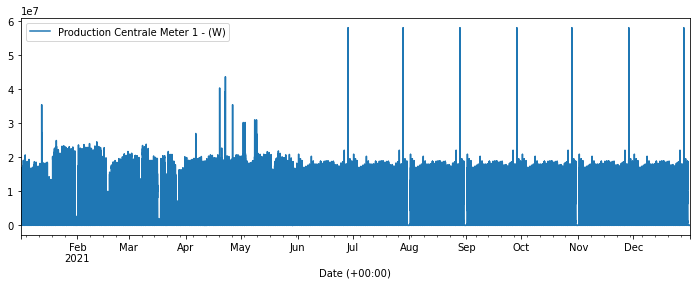

In [7]:
energie.plot(figsize=(12,4))

In [8]:
# GESTION DES VALEURS MANQUANTES
energie=energie.dropna()
energie.isnull().sum()

Production Centrale Meter 1 - (W)    0
dtype: int64

In [9]:
energie.describe()

,Production Centrale Meter 1 - (W)
count,1.045020e+05
mean,4.486998e+06
std,6.034425e+06
min,0.000000e+00
25%,0.000000e+00
50%,1.356000e+05
75%,9.030000e+06
max,5.817720e+07


<AxesSubplot:xlabel='Date (+00:00)'>

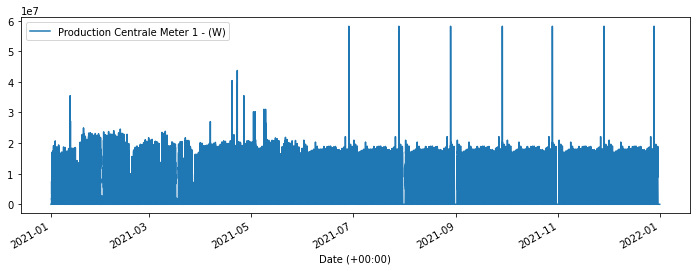

In [10]:
energie.plot(figsize=(12,4))

### a) Analyse des donnees
- Detection de tendance
- les saisonalites
- composentes anormaux

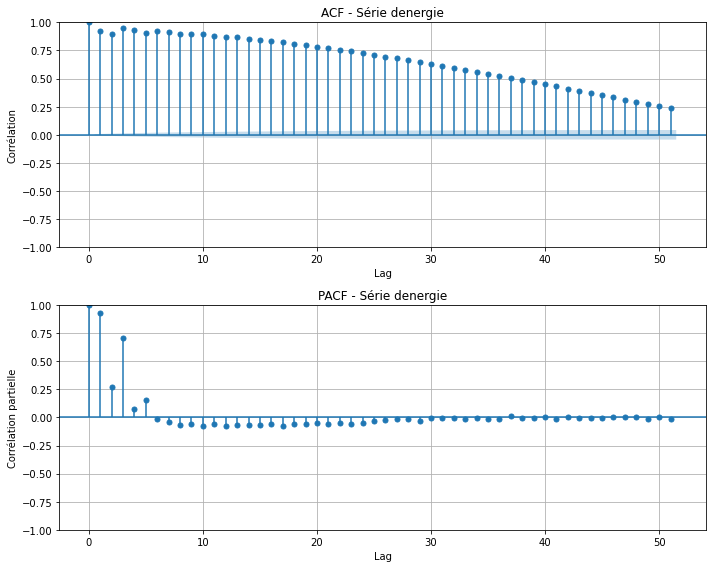

In [11]:
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(energie[energie.columns],zero=True, ax=ax1)
ax1.set_title('ACF - Série d''energie')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
#ax1.set_xticks(np.arange(0,energie.columns[0] , 1))

# Tracer le PACF
plot_pacf(energie[energie.columns],zero=True, ax=ax2)
ax2.set_title('PACF - Série d''energie')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
#ax2.set_xticks(np.arange(0,energie.columns[0], 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

In [12]:
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(energie)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion',
     'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -40.15731398277056        |
| P-valeur       | 0.0                       |
| Conclusion     | La série est stationnaire |


In [13]:
# Effectuer la décomposition saisonnière
decomposition = seasonal_decompose(energie['Production Centrale Meter 1 - (W)'], model='additive',period=energie.shape[0])
"""
# Extraire les composantes de la décomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Afficher les composantes de la décomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(energie['Production Centrale Meter 1 - (W)'], label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
"""

ValueError: x must have 2 complete cycles requires 209004 observations. x only has 104502 observation(s)

### b) Differentisation

In [14]:
size_train=round(0.8*energie.shape[0])

energie_train=energie.iloc[:size_train]
energie_teste=energie.iloc[size_train:]


In [15]:
modele=auto_arima(energie_train)

print(modele.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                83602
Model:               SARIMAX(5, 0, 4)   Log Likelihood            -1306042.603
Date:                Sun, 01 Oct 2023   AIC                        2612107.205
Time:                        14:33:16   BIC                        2612209.877
Sample:                             0   HQIC                       2612138.616
                              - 83602                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.294e+04   3.91e-09   1.61e+13      0.000    6.29e+04    6.29e+04
ar.L1          0.4450      0.006     75.590      0.000       0.433       0.457
ar.L2          0.8600      0.008    102.861      0.0

### c) Identification des ordres
- ACF
- PACF

In [16]:
# Ajuster le modèle aux données
modele_fit=modele.fit(energie_train)

## 3. Estimation du modele

### Estimation des parametres
- MCO

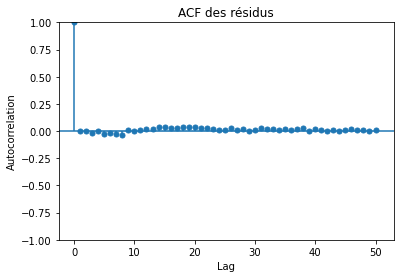

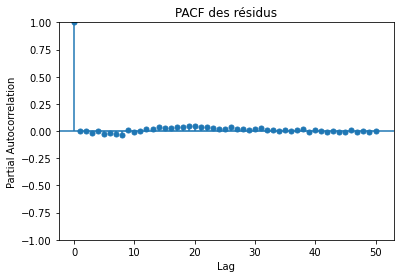

In [17]:
# Obtenir les résidus du modèle
residuals = modele_fit.resid()

# Tracer la fonction d'autocorrélation (ACF) des résidus
plot_acf(residuals)#, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF des résidus')
plt.show()

# Tracer la fonction d'autocorrélation partielle (PACF) des résidus
plot_pacf(residuals)#, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF des résidus')
plt.show()

## 4. Verification du modele

### a) Diagnostique du modele

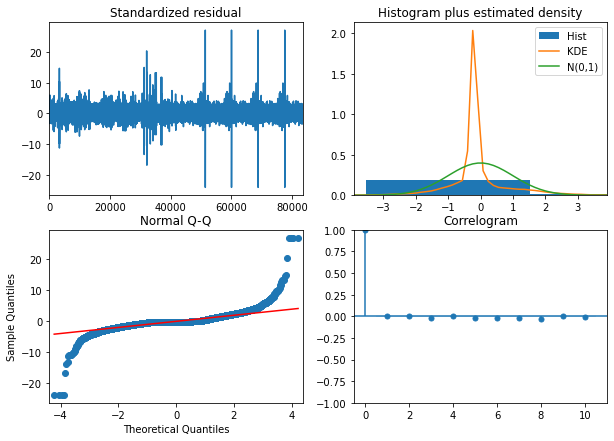

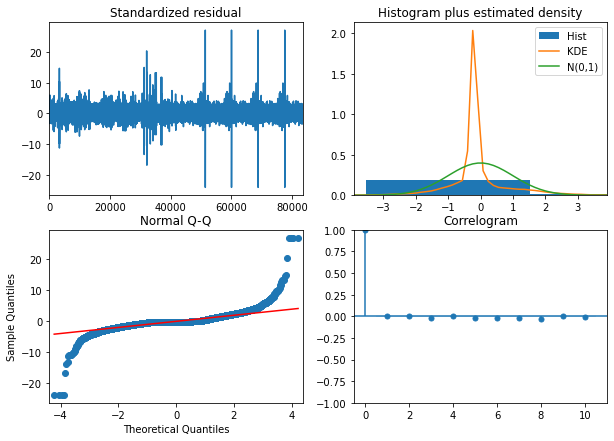

In [18]:
modele_fit.plot_diagnostics(figsize=(10, 7))

### b) Reajustement

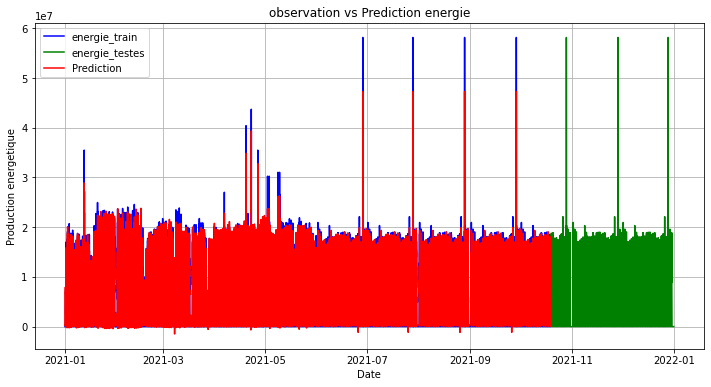

In [19]:
# Faire des prédictions sur l'ensemble d'entraînement
train_pred, train_confint = modele.predict_in_sample(return_conf_int=True)

# Faire des prédictions sur l'ensemble de test
n_periods = len(energie_train)
predicted, confint = modele_fit.predict(n_periods=n_periods, return_conf_int=True)

# Concaténer les prédictions pour l'ensemble d'entraînement et de test
all_predictions = pd.concat([pd.Series(train_pred, index=energie_train.index), 
                             pd.Series(predicted, index=energie_train.index)], 
                            axis=0)

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(energie_train, label='energie_train', color='blue')
plt.plot(energie_teste, label='energie_testes', color='green')
plt.plot(all_predictions, label='Prediction', color='red')

plt.xlabel('Date')
plt.ylabel('Production energetique')
plt.title('observation vs Prediction energie')
plt.legend()
plt.grid(True)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

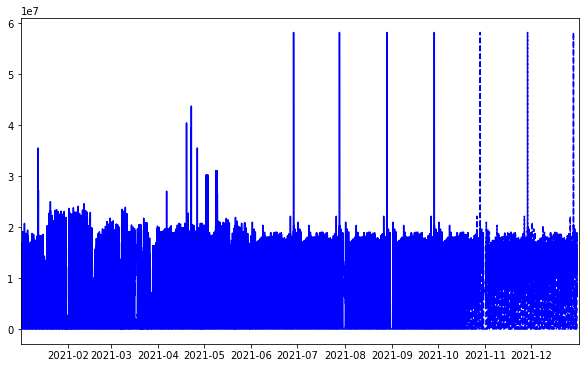

In [20]:
# Prédictions sur l'ensemble d'entraînement
train_predictions = modele_fit.predict(start=energie_train.index[0], end=energie_train.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = modele_fit.predict(start=energie_teste.index[0], end=energie_teste.index[-1])

# Prédictions sur l'ensemble d'entraînement
train_predictions = modele_fit.predict(start=energie_train.index[0], end=energie_train.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = modele_fit.predict(start=energie_teste.index[0], end=energie_teste.index[-1])

# Tracer les prédictions et les données réelles avec les courbes collées
plt.figure(figsize=(10, 6))
plt.plot(energie_train.index, energie_train.values, label='Ensemble d\'entraînement', color='blue')
plt.plot(energie_teste.index, energie_teste.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(train_predictions.index, train_predictions, label='Prédictions (Entraînement)', color='red')
plt.plot(test_predictions.index, test_predictions, label='Prédictions (Test)', color='green')

# Définir les limites des axes x et y pour une continuité visuelle
plt.xlim(energie_train.index[0], energie_teste.index[-1])
plt.ylim(0, energie.max())
#plt.ylim(min(energie_train.min(), energie_teste.min()), max(energie_train.max(), energie_teste.max()))
"""
plt.xlabel('Date')
plt.ylabel('production')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()
"""

### c) Validation

In [ ]:
# Calculer les mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(energie_train, train_pred)
train_mse = mean_squared_error(energie_train, train_pred)
train_rmse = mean_squared_error(energie_train, train_pred, squared=False)
train_r2 = r2_score(energie_train, train_pred)

# Calculer les mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(energie_teste, predicted)
test_mse = mean_squared_error(energie_teste, predicted)
test_rmse = mean_squared_error(energie_teste, predicted, squared=False)
test_r2 = r2_score(energie_teste, predicted)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)

ValueError: Found input variables with inconsistent numbers of samples: [20900, 83602]